<td>
   <a target="_blank" href="https://labelbox.com" ><img src="https://labelbox.com/static/images/logo-v4.svg" width=256/></a>
</td>

<td>
<a href="https://colab.research.google.com/github/Labelbox/labelbox-python/blob/develop/examples/annotation_types/basics.ipynb" target="_blank"><img
src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</td>

<td>
<a href="https://github.com/Labelbox/labelbox-python/tree/develop/examples/annotation_types/basics.ipynb" target="_blank"><img
src="https://img.shields.io/badge/GitHub-100000?logo=github&logoColor=white" alt="GitHub"></a>
</td>

## Annotation Types
This is a common format for representing human and machine generated annotations. A standard interface allows us to build one set of tools that is compatible with all of our data. For example, if model predictions and labels are all represented by a common format we can write all of our etl, visualization code, training code to work with a single interface. Annotation types can also provide a seamless transition between local modeling and using labelbox. Some of the helper functions include:
* Build annotations locally with local file paths, numpy arrays, or urls and create data rows with a single line of code
* Easily upload model predictions for MAL or MEA by converting annotation objects to the import format
* Configure project ontologies from a set of model inferences
* Easily access video data without having to worry about downloading each frame's annotations.
* Helper functions for drawing annotations, converting them into shapely objects, and much more.

------- 
## Installation
* Installing annotation types requires a slightly different pattern
    - `pip install "labelbox[data]"`
* `pip install labelbox` is still valid but it won't add the required dependencies. If you only want the client functionality of the SDK then don't add the [data] extras. However, you will likely get import errors if attempting to use the annotation types

In [ ]:
!pip install "labelbox[data]"

## Imports
* All annotation types can be imported from `labelbox.data.annotation_types`
* Helper functions that are compatible with annotation types can be found under `labelbox.data`

In [ ]:
from labelbox.data.annotation_types import (
    Label, ImageData, MaskData, LabelList, TextData, VideoData,
    ObjectAnnotation, ClassificationAnnotation, Polygon, Rectangle, Line, Mask,
    Point, Checklist, Radio, Text, TextEntity, ClassificationAnswer)
from labelbox import (LabelingFrontend, Client, OntologyBuilder, Tool,
                      Classification, Option, MediaType)
from labelbox.schema.queue_mode import QueueMode
from shapely.ops import transform
from shapely.affinity import affine_transform
import requests
import IPython
from PIL import Image
from io import BytesIO
import numpy as np
import os

# API Key and Client
Provide a valid api key below in order to properly connect to the Labelbox Client.

In [ ]:
# Add your api key
API_KEY = None
client = Client(api_key=API_KEY)

# Variables
image_url_example = "https://picsum.photos/id/1003/200/300"
text_file_example = "https://storage.googleapis.com/labelbox-datasets/tweet_sentiment/44953.txt"
video_url_example = "http://commondatastorage.googleapis.com/gtv-videos-bucket/sample/ForBiggerMeltdowns.mp4"


## Basic Introduction
* Construct annotations, labels, and label collections to create a common representation for all data
    * A `LabelCollection` is essentially a list or generator for working with a collection of Labels
    * A `Label` is a type of data and its associated annotations. E.g. an image and image annotations
    * An annotation is either an `ObjectAnnotation` or a `ClassificationAnnotation`. These annotations contain a name and a `Geometry`, `Classification`, or some `Text` data. They also support a classifications field for subclasses.
* In addition to create common interfaces for reducing the amount of etl work, each of these types have a set of helper functions that make ML workflows much easier.

### Constructing Annotation Objects
* Annotation objects can be created in one of three ways:
1. Manually construct them - usually used for model inferences
    - Covered in this notebook
2. Export labels to an annotation generator
    - `project.label_generator()`
3. Use a converter to load from another format
    - Covered in the converters.ipynb notebook.

### Basic LabelCollection
* A Label collection is either a `labelList` or `LabelGenerator` containing `Labels`
    * More on this in label_containers.ipynb
* Each label contains:
    1. Data
    2. Annotations associated with that data
* The individual data and annotations will be explained below

In [ ]:
labels = [
    Label(
        data=ImageData(url=image_url_example),
        annotations=[ObjectAnnotation(value=Point(x=25, y=30), name="target")])
]
labels = LabelList(labels) 

* All models are pydantic models so we can easily convert all of our objects to dictionaries and view the schema.

In [ ]:
labels[0].schema()
labels[0].dict()

{'uid': None,
 'data': {'external_id': None,
  'uid': None,
  'media_attributes': None,
  'metadata': None,
  'im_bytes': None,
  'file_path': None,
  'url': 'https://picsum.photos/id/1003/200/300',
  'arr': None},
 'annotations': [{'name': 'target',
   'feature_schema_id': None,
   'extra': {},
   'value': {'extra': {}, 'x': 25.0, 'y': 30.0},
   'classifications': []}],
 'extra': {}}

# Data 
* There are three classes to represent data
    * TextData
    * VideoData
    * ImageData
* The data objects can be constructed from various representations
    - remote (url, uri)
    - disk ( file path)
    - compressed (image bytes)
    - memory ( numpy array )
* Then the access pattern is consistent regardless of the format used to construct the object


### ImageData

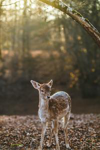

In [ ]:
# Data can be instantiated with any of the following
image = ImageData(im_bytes=b'bytes')
image = ImageData(arr=np.zeros((10, 10, 3)).astype(np.uint8))
image = ImageData(file_path='/tmp/img.jpg') 
image = ImageData(url=image_url_example)
# All of these can access the numpy representation the same way:
np_data = image.value

im = Image.fromarray(np_data)
im.resize((im.size[0] // 2, im.size[1] // 2))

### TextData

In [ ]:
# Text has the same access pattern as imagery.
text = TextData(file_path="/tmp/some local file.txt")
text = TextData(text=" some text content...")
text = TextData(url=text_file_example)

print(text.value[:100])

TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out 


### VideoData

In [ ]:
video = VideoData(file_path="some video path.mp4")
video = VideoData(frames={1: np.zeros((32, 32, 3), dtype=np.uint8)})
video = VideoData(url=video_url_example)

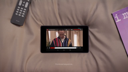

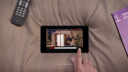

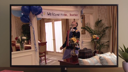

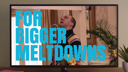

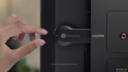

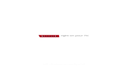

In [ ]:
for idx, frame in video.value:
    # Show every 50th frame
    if idx % 50 == 0:
        video_im = Image.fromarray(frame)
        w, h = video_im.size
        IPython.display.display(video_im.resize((w // 10, h // 10)))
    if idx > 250:
        break

### Advanced

#### Adding data row information
* This is not required ( and can be added at a later time but you can add data row information to your data)


In [ ]:
td = TextData(text="some text",
              uid="ckrey6o07000008l50uk2gcr3",
              external_id="my_text_data_row")
rd = ImageData(url=image_url,
               uid="ckrey7te2000108l5hl8564dr",
               external_id="my_raster_data_row")
vd = VideoData(url=video_url,
               uid="ckrey7xef000208l57hwfgi3v",
               external_id="my_video_data_row")

print(td)
print(rd)
print(vd)

external_id='my_text_data_row' uid='ckrey6o07000008l50uk2gcr3' media_attributes=None metadata=None file_path=None text='some text' url=None
external_id='my_raster_data_row' uid='ckrey7te2000108l5hl8564dr' media_attributes=None metadata=None im_bytes=None file_path=None url='https://storage.googleapis.com/labelbox-datasets/Catalog_E2E/Lookout_in_Hungary.jpg' arr=None
external_id='my_video_data_row' uid='ckrey7xef000208l57hwfgi3v' media_attributes=None metadata=None file_path=None url='http://commondatastorage.googleapis.com/gtv-videos-bucket/sample/ForBiggerMeltdowns.mp4' frames=None


#### Non-public urls
* If the urls in your data is not publicly accessible you can override the fetching logic
* For `TextData` and `ImageData` overwrite the following function and make sure it has the same signature. `data.fetch_remote(self) -> bytes`.
* For `VideoData`, the signature is `VideoData.fetch_remote(self, local_path)`. This function needs to download the video file locally to that local_path to work.

In [ ]:
image.set_fetch_fn(lambda self: requests.get(self.url, headers={...}).content)

# Annotations

* There are 4 types of annotations
    1. `ObjectAnnotation`
        - Objects with location information
        - Annotations that are found in the object field of the labelbox export
        - Classes: `Point`, `Polygon`, `Mask`, `Line`, `Rectangle`, `TextEntity`
    2. `ClassificationAnnotation`
        - Classifications that can apply to data or another annotation
        - Classes: `Checklist`, `Radio`, `Text`, `Dropdown`
    3. `VideoObjectAnnotation`
        - Same as object annotation but there are extra fields for video information
    4. `VideoClassificationAnnotation`
        - Same as classification annotation but there are extra fields for video information    
-------- 
* Create an annotation by providing the following:
1. Value
    - Must be either a `Geometry`, `TextEntity`, or `Classification`
    - This is the same as a top level tool in labelbox
2. Name or feature_schema_id
    - This is the id that corresponds to a particular class or just simply the class name
    - If uploading to labelbox this must match a field in an ontology.
3. (Optional) Classifications 
    - List of `ClassificationAnnotations`. This self referencing field enables infinite nesting of classifications.
    - Be careful with how you use the tool. Labelbox does not support nesting classifications
    - E.g. you can have tool.classifications but not tool.classifications[0].classifications
        

### ObjectAnnotation

##### Point

In [ ]:
point_annotation = ObjectAnnotation(value=Point(x=5, y=3),
                                    name="point class name")

point_annotation = ObjectAnnotation(
    value=Point(x=5, y=3), feature_schema_id="ckrgcgl89000108jtggc9e687")

##### Polygon

In [ ]:
# Given some polygon:
xy_poly = [
    [60, 161],
    [67, 177],
    [76, 180],
    [77, 222],
    [82, 246],
    [78, 291],
    [72, 300],
    [87, 300],
    [94, 244],
    [103, 243],
    [100, 269],
    [90, 290],
    [95, 296],
    [104, 292],
    [108, 272],
    [111, 300],
    [121, 300],
    [117, 244],
    [128, 236],
    [133, 298],
    [142, 297],
    [137, 250],
    [146, 208],
    [138, 185],
    [120, 180],
    [105, 189],
    [112, 162],
    [93, 156],
    [72, 160],
]

polygon_annotation = ObjectAnnotation(
    value=Polygon(points=[Point(x=x, y=y) for x, y in xy_poly]),
    name="polygon class name")

polygon_annotation = ObjectAnnotation(
    value=Polygon(points=[Point(x=x, y=y) for x, y in xy_poly]),
    feature_schema_id="ckrgcel71000008jtd9mn0szu")

##### Line

In [ ]:
xy_line = [[0, 0], [10, 5], [15, 5]]

line_annotation = ObjectAnnotation(
    value=Line(points=[Point(x=x, y=y) for x, y in xy_line]),
    name="line class name")

line_annotation = ObjectAnnotation(
    value=Line(points=[Point(x=x, y=y) for x, y in xy_line]),
    feature_schema_id="ckrgcel71000008jtd9mn0szu")

##### Rectangle

In [ ]:
start = Point(x=0, y=0)
end = Point(x=5, y=10)

rectangle_annotation = ObjectAnnotation(value=Rectangle(start=start, end=end),
                                        name="rectangle class name")

rectangle_annotation = ObjectAnnotation(
    value=Rectangle(start=start, end=end),
    feature_schema_id="ckrgcel71000008jtd9mn0szu")

##### Mask
* The mask can be any ImageData object.


In [ ]:
mask_annotation = ObjectAnnotation(value=Mask(
    mask=MaskData(arr=np.zeros((32, 32, 3), dtype=np.uint8)),
    color=(255, 255, 255)),
                                   name="mask class name")

mask_annotation = ObjectAnnotation(
    value=Mask(mask=MaskData(arr=np.zeros((32, 32, 3), dtype=np.uint8)),
               color=(255, 255, 255)),
    feature_schema_id="ckrgcel71000008jtd9mn0szu")

* Multiple mask objects can reference the same mask to save memory and reduce the number of files that need to be uploaded (i.e. one seg mask for multiple classes).



In [ ]:
raster_data = MaskData(arr=np.zeros((32, 32, 3), dtype=np.uint8))
mask_annotation = ObjectAnnotation(value=Mask(mask=raster_data,
                                              color=[255, 255, 255]),
                                   name="eyes")

mask_annotation = ObjectAnnotation(value=Mask(mask=raster_data,
                                              color=[0, 255, 255]),
                                   name="nose")

* The Mask class support either RGB masks only

In [ ]:
raster_data = MaskData(arr=np.zeros((32, 32, 3), dtype=np.uint8))
mask_annotation = ObjectAnnotation(value=Mask(mask=raster_data,
                                              color=(128, 255, 255)),
                                   name="eye")

mask_annotation = ObjectAnnotation(value=Mask(mask=raster_data,
                                              color=(255, 255, 255)),
                                   name="nose")

##### Text Entity

In [ ]:
entity_annotation = ObjectAnnotation(value=TextEntity(start=10, end=12),
                                     name="person")

entity_annotation = ObjectAnnotation(
    value=TextEntity(start=10, end=12),
    feature_schema_id="ckrgddyli000108mk0c0t9qya")

##### Geometry Utilities
* All of the previous objects except TextEntity inherit from the Geometry base class
* They have the following properties and functions
    1. draw(height width, kwargs)
    2. shape - property
    3. geometry - property

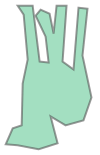

In [ ]:
polygon_annotation.value.shapely

* Flip because shapely origin is different from image coords
```
      Shapely Coordinates           Image Coordinates
           ------                        -------    
                               0 → → Greater X → →
    ↑                          ↓
Greater Y                    ↓
    ↑                       Greater Y
    ↑                          ↓
    0 → → Greater X → →
```

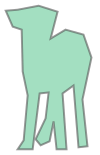

In [ ]:
def flip_y_axis(poly, height):
    return affine_transform(poly, [1, 0, 0, -1, 0, height])


flip_y_axis(polygon_annotation.value.shapely, im.size[1])

##### Shape to Mask

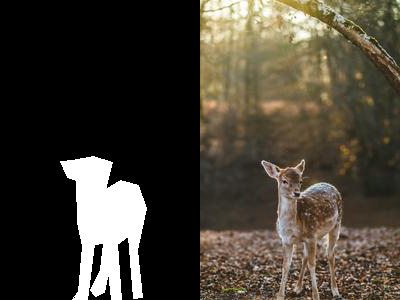

In [ ]:
color = (255, 255, 255)
np_mask = polygon_annotation.value.draw(height=im.size[1],
                                        width=im.size[0],
                                        color=color)
Image.fromarray(np.hstack([np_mask, np_data]))

##### Mask to Shape
* Adds extra vertices to be as accurate as possible

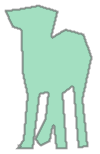

In [ ]:
mask_annotation = Mask(mask=MaskData(arr=np_mask), color=color)

flip_y_axis(mask_annotation.shapely, im.size[1])
# Simplify with mask_annotation.shapely.simplify(<float> simplification error tolerance)

#### Masks with multiple annotations
* Since masks can contain multiple classes you can split them up by calling raster on an individual annotation.
* E.g. eyes and nose for our deer image

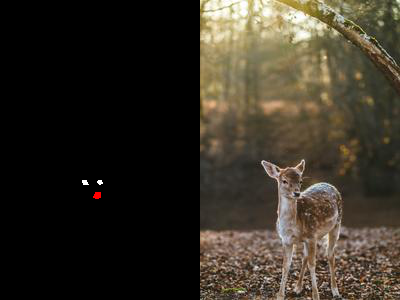

In [ ]:
# Build a combined mask from polygons
eye_color, nose_color = (255, 255, 255), (255, 0, 0)
h, w = np_data.shape[:2]
eyes = [
    Polygon(points=[
        Point(x=x, y=y) for x, y in [[82, 180], [83, 184], [88, 184], [86, 180]]
    ]),
    Polygon(points=[
        Point(x=x, y=y)
        for x, y in [[97, 182], [99, 184], [102, 183], [101, 180], [98, 180]]
    ]),
]
eye_masks = np.max([eye.draw(height=h, width=w) for eye in eyes], axis=0)
nose = Polygon(points=[
    Point(x=x, y=y) for x, y in [[95, 192], [93, 197], [96, 198], [100, 197],
                                 [100, 194], [100, 192], [96, 192]]
])
nose_mask = nose.draw(height=h, width=w, color=nose_color)
# Picks the brighter color if there is overlap.
# If you don't want overlap then just simply create separate masks
np_seg_mask = np.max([nose_mask, eye_masks], axis=0)
Image.fromarray(np.hstack([np_seg_mask, np_data]))

* Create two mask annotations from this one image

In [ ]:
mask_data = MaskData(arr=np_seg_mask)
eye_mask = Mask(mask=mask_data, color=eye_color)
nose_mask = Mask(mask=mask_data, color=nose_color)

* Calling `mask.draw()` will return a mask with pixels equal to the specified color

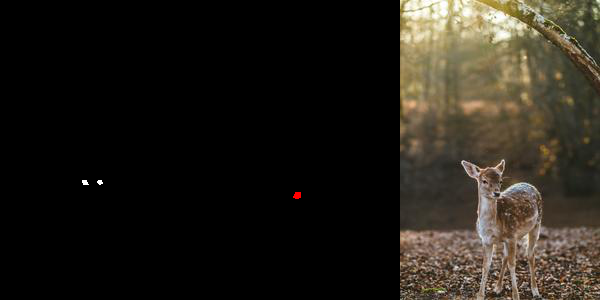

In [ ]:
eye_raster = eye_mask.draw()
nose_raster = nose_mask.draw()
Image.fromarray(np.hstack([eye_raster, nose_raster, np_data]))

### Classification Annotation

#### Text

In [ ]:
text_annotation = ClassificationAnnotation(
    name="my text class", value=Text(answer="some text answer"))

text_annotation = ClassificationAnnotation(
    feature_schema_id="my text class", value=Text(answer="some text answer"))

#### Radio

In [ ]:
radio_annotation = ClassificationAnnotation(
    name="is dog", value=Radio(answer=ClassificationAnswer(name="dog")))

radio_annotation = ClassificationAnnotation(
    feature_schema_id="ckresqdg7000001jnb70v4zcc",
    value=Radio(answer=ClassificationAnswer(
        feature_schema_id="ckrdy06ia000007ky94h04qlj")))

##### Checklist

In [ ]:
checklist_annotation = ClassificationAnnotation(
    feature_schema_id="ckrestd5g000101jnhudjf29a",
    value=Checklist(answer=[
        ClassificationAnswer(feature_schema_id="ckrdy06ia000007ky94h04qlj")
    ]))

checklist_annotation = ClassificationAnnotation(
    name="weather",
    value=Checklist(answer=[ClassificationAnswer(name="cloudy")]))

### Subclassifications
* Objects can have nested classifications

In [ ]:
subclass_annotation = ObjectAnnotation(
    value=Polygon(points=[Point(x=x, y=y) for x, y in xy_poly]),
    name="deer",
    classifications=[checklist_annotation, radio_annotation])

# Labels
* Labels connect a list of annotations to data such as images, text, and video.
* Labels have a convenient set of functions for dealing with that collection of data

In [ ]:
label = Label(data=ImageData(url=image_url_example),
              annotations=[
                  ObjectAnnotation(value=Polygon(
                      points=[Point(x=x, y=y) for x, y in xy_poly]),
                                   name="deer"),
                  ObjectAnnotation(name="deer_eyes",
                                   value=Mask(mask=MaskData(arr=np_mask),
                                              color=color))
              ])

### Interacting with labelbox:
* For this label to be compatible with labelbox we need the following:
    - all named features must have feature_schema_ids
    - all data must have urls
        - masks
        - images
        - videos
        - text
    

### Uploading Urls
* It doesn't matter how urls are set
* Manually setting urls or use helper functions are both valid for working with labelbox

In [ ]:
# Manually set just by adding a value:
image = ImageData(arr=np_data)
image.url = "http://myurl"

* Use functions to upload urls:
    - Upload image urls : `Label.add_url_to_data(signer)`
    - Upload segmentation masks : `label.add_url_to_masks(signer)`

----- 
* Define the signer
    - Creating urls requires a function that maps bytes to a str (url)

In [ ]:
def signing_function(obj_bytes: bytes) -> str:
    # Do not use this signer. You will not be able to resign these images at a later date
    url = client.upload_data(content=obj_bytes, sign=True)
    return url

* Create a complex label

In [ ]:
label = Label(
    data=ImageData(arr=np_data),
    annotations=[
        ObjectAnnotation(
            name="deer_nose",
            value=nose_mask,
            classifications=[
                ClassificationAnnotation(
                    name="description",
                    value=Radio(answer=ClassificationAnswer(name="wet")))
            ]),
        ObjectAnnotation(name="deer_eyes", value=eye_mask),
        ObjectAnnotation(
            value=Polygon(points=[Point(x=x, y=y) for x, y in xy_poly]),
            name="deer"),
        ClassificationAnnotation(name="image_description",
                                 value=Checklist(answer=[
                                     ClassificationAnswer(name="bright"),
                                     ClassificationAnswer(name="not_blurry"),
                                 ])),
    ])

* Check that the image does not have a url
* Add the url
* Check that the url was added

In [ ]:
print("Before", label.data.url)
label.add_url_to_data(signing_function)
print("After", label.data.url)

Before None
After https://storage.labelbox.com/cl3ahv73w1891087qbwzs3edd%2F305c0d73-e298-ae15-b914-f76186981d5e-1?Expires=1663963034564&KeyName=labelbox-assets-key-3&Signature=KQhtpVLmm8p7IdWn0jK2hP9SkxE


* Masks also need urls for annotation imports
* Note that the url is the same when uploaded.
    - The url is only uploaded once

In [ ]:
# We also have a mask that needs a url:
mask_annotations = [
    annot for annot in label.annotations if isinstance(annot.value, Mask)
]
for annot in mask_annotations:
    print(f"{annot.name} before", annot.value.mask.url)

label.add_url_to_masks(signing_function)

for annot in mask_annotations:
    print(f"{annot.name} after", annot.value.mask.url)

deer_nose before None
deer_eyes before None
deer_nose after https://storage.labelbox.com/cl3ahv73w1891087qbwzs3edd%2F7f40e1dd-cf06-f911-f9da-d146925c9b22-1?Expires=1663962901679&KeyName=labelbox-assets-key-3&Signature=13beyydpxSoCLCw3QnQ96rRkQN8
deer_eyes after https://storage.labelbox.com/cl3ahv73w1891087qbwzs3edd%2F7f40e1dd-cf06-f911-f9da-d146925c9b22-1?Expires=1663962901679&KeyName=labelbox-assets-key-3&Signature=13beyydpxSoCLCw3QnQ96rRkQN8


### Creating Data Rows
* `Labels` objects are great for working with locally but we might want to upload to labelbox
* This is required for MAL, MEA, and to add additional labels to the data. To learn about MAL : https://docs.labelbox.com/reference/model-assisted-labeling-mal


In [ ]:
dataset = client.create_dataset(name="label_dataset")

In [ ]:
# Note that the signing function is only used if a url is not already provided
print(label.data.uid)
label.create_data_row(dataset, signing_function)
print(label.data.uid)

None
cl8dh8iuc04jl07ydb7g748nw


### Assigning Schema Ids:
* All tools, classifications, and options either have names or feature_schema_ids.
* Locally it is convenient to provide a name so that we don't need a labelbox project to use these interfaces.

In [ ]:
# When uploading for MAL or MEA we need an ontology.
# So let's create one

# These names have to match our object names exactly!!
ontology_builder = OntologyBuilder(tools=[
    Tool(tool=Tool.Type.POLYGON, name="deer"),
    Tool(tool=Tool.Type.SEGMENTATION,
         name="deer_nose",
         classifications=[
             Classification(class_type=Classification.Type.RADIO,
                            instructions="description",
                            options=[Option(value="wet")])
         ]),
    Tool(tool=Tool.Type.SEGMENTATION, name="deer_eyes")
],
                                   classifications=[
                                       Classification(
                                           Classification.Type.CHECKLIST,
                                           instructions="image_description",
                                           options=[
                                               Option(value="bright"),
                                               Option(value="not_blurry"),
                                               Option(value="dark")
                                           ])
                                   ])

editor = next(
    client.get_labeling_frontends(where=LabelingFrontend.name == "Editor"))
project = client.create_project(name="test_annotation_types", 
                                queue_mode=QueueMode.Batch,
                                media_type=MediaType.Image)
project.setup(editor, ontology_builder.asdict())
data_rows = [row.uid for row in dataset.export_data_rows()]
batch = project.create_batch(
    "test_annotation_types",
    data_rows,
    5
)

ontology = OntologyBuilder.from_project(project)

### Next Steps
* Annotation types should be thought of as low level interfaces
* We are working on a set of tools to make working with annotation types less verbose. Please provide any feedback!
* Checkout other notebooks to see how to use higher level tools that are compatible with these interfaces: https://docs.labelbox.com/reference/sdk-tutorials-1

In [ ]:
# Cleanup
dataset.delete()
project.delete()